# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, autograd as ag
import scipy.stats as st
import random
from tqdm import tqdm

from model import *
from dataset import *
from utils import *

In [2]:
hyperparams = {
        'n_tasks': 1000,
        'n_episode': 150,
        'n_timesteps': 10,
        'input_dim': 2, 
        'hidden_dim': 512,
        'output_dim': 2,
        'lr': 1e-4,
        'batch_size': 128,
        'n_epochs': 100,
        }

# Load model

In [3]:
model_multiTask = "Task1_multiTask.pth.tar"
model_reptile = "Task1_reptile.pth.tar"

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
def load_model(n_particle=1, model_name=model_reptile):
    model = MyModel(input_dim=hyperparams['input_dim'], hidden_dim=hyperparams['hidden_dim'],
                    output_dim=hyperparams['output_dim'], n_particle=n_particle).to(device)
    checkpoint = torch.load(model_name, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

# Load data

In [5]:
dataset = torch.load('./two_links_arm_test')
adapt_data = [data['adapt'] for data in dataset]
test_data = [data['test'] for data in dataset]

# Adaptation 

In [6]:
def smcd(T, N, adapt_data, d=0.05):
    '''
    model: neural network
    T: adaptation timestep
	N: particle numbers
	adapt_data: as name
	d: flip rate
	'''
    model = load_model(n_particle=N)
    q = adapt_data['angle']
    # z = adapt_data['noisy_pos']
    z = adapt_data['true_pos']
    n_features = model.get_dropout_mask().shape[1]
	# initialize M_0
    # M = np.random.randint(low=0,high=2,size=(n_features, N))
    M = np.ones((n_features, N), dtype=np.int8)
    M_best = np.ones(n_features)
    assert T <= q.shape[-1], f'T should be less than {q.shape[-1]}'
    assert not model.training, f'please call model.eval()'
    M_bests = []
    for t in tqdm(range(T)):
        M = flip(M,d)
        M[:,0] = M_best # replace one particle by the last best one (no mutation for the last champion particle)
        # w = []
        model.update_dropout_mask(M.swapaxes(1,0))
        X = model(q[:,t].to(device, dtype=torch.float32)).detach().numpy()
        # for i in range(N):
        #     w_i = st.multivariate_normal.pdf(z[:,t].detach().numpy(), mean=X[i], cov=0.001)
        #     w.append(w_i)
        # to benefit from vectorization we replace p(z_t|x_i) by p(x_i|z_t)
        logW = st.multivariate_normal.logpdf(X, mean=z[:,t].detach().numpy(), cov=0.0001)
        W = exp_and_normalise(logW)
        # print(W.shape)
        # print(w)
        # N_eff = int(1 / np.sum((np.asarray(w)) ** 2))
        # print(N_eff)
        if W.sum() != 0: #if w not valid, no update for M_best
            resample_index = resample(range(N), W)
            M = np.take(M, resample_index, axis=1)
            M_best = (M.mean(axis=1) > 0.5).astype(np.int_)
        M_bests.append(M_best)
    return M_bests

In [7]:
def adapt_GD(adapt_data):
    def totorch(x):
        return ag.Variable(torch.FloatTensor(x).to(device))
    
    def train_on_batch(x, y):
        x = totorch(x)
        y = totorch(y)
        optimizer.zero_grad()
        ypred = model.forward(x)
        loss = criterion(ypred, y)
        loss.backward()
        optimizer.step()
        return loss
    
    model = load_model()
    model.train()
    criterion = nn.MSELoss()
    losses = []
    batch_size = 16
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])
    x_train = adapt_data['angle'].to(torch.float32).swapaxes(1,0)
    y_train = adapt_data['noisy_pos'].to(torch.float32).swapaxes(1,0)
    inds = torch.randperm(len(x_train))
    for start in range(0, len(x_train), batch_size):
        mbinds = inds[start:start+batch_size]
        losses.append(train_on_batch(x_train[mbinds], y_train[mbinds]).item())
    return np.mean(losses)

In [8]:
def compare_adaptation(n_tasks=len(adapt_data), adapt_timestep=10, n_particles=300):
    losses = []
    losses_no_adapt = []
    losses_GD = []
    criterion = nn.MSELoss()
    M_best_per_task = []
    for i in range(n_tasks):
        model = load_model()
        q = adapt_data[i]['angle'].to(torch.float32).swapaxes(1,0)
        x = adapt_data[i]['true_pos'].to(torch.float32).swapaxes(1,0)
        x_noadapt = model(q).detach()
        loss_GD = adapt_GD(adapt_data[i])
        
        M_best = smcd(adapt_timestep, n_particles, adapt_data[i], d=0.15)
        M_best_per_task.append(M_best[-1].reshape(1,-1))
        model.update_dropout_mask(M_best[-1].reshape(1,-1))
        x_pred = model(q).detach()
        
        loss = criterion(x_pred, x).item()
        loss_no_adapt = criterion(x_noadapt, x).item()
        # print(f"For {i}th task, loss after adaptation is {round(loss.item(), 3)}, limb length is {dataset.l[i]}")
        # print(f"For {i}th task, loss after adaptation is {round(loss.item(), 3)}, No adaptation loss is {round(loss_no_adapt.item(), 3)}, limb length is {dataset.l[i]}")
        print(f"For {i}th task, loss with SMCD is {round(loss, 3)}, "
          f"loss with GD is {round(loss_GD, 3)}, "
          f"loss wto adaptation is {round(loss_no_adapt, 3)}.")
        losses.append(loss)
        losses_no_adapt.append(loss_no_adapt)
        losses_GD.append(loss_GD)
    return losses, losses_no_adapt, losses_GD, M_best_per_task

In [9]:
loss_smcd, loss_N, loss_GD, M_best_per_task = compare_adaptation(n_tasks=20, adapt_timestep=100, n_particles=1000)

100%|██████████| 100/100 [00:01<00:00, 59.49it/s]


For 0th task, loss with SMCD is 1.848, loss with GD is 1.707, loss wto adaptation is 1.907.


100%|██████████| 100/100 [00:01<00:00, 56.63it/s]


For 1th task, loss with SMCD is 0.861, loss with GD is 1.161, loss wto adaptation is 1.423.


100%|██████████| 100/100 [00:01<00:00, 58.41it/s]


For 2th task, loss with SMCD is 0.615, loss with GD is 0.857, loss wto adaptation is 1.198.


100%|██████████| 100/100 [00:01<00:00, 56.05it/s]


For 3th task, loss with SMCD is 0.202, loss with GD is 0.716, loss wto adaptation is 1.069.


100%|██████████| 100/100 [00:01<00:00, 56.50it/s]


For 4th task, loss with SMCD is 2.032, loss with GD is 2.223, loss wto adaptation is 2.931.


100%|██████████| 100/100 [00:01<00:00, 60.02it/s]


For 5th task, loss with SMCD is 1.461, loss with GD is 1.777, loss wto adaptation is 2.114.


100%|██████████| 100/100 [00:01<00:00, 57.31it/s]


For 6th task, loss with SMCD is 0.758, loss with GD is 1.265, loss wto adaptation is 1.686.


100%|██████████| 100/100 [00:01<00:00, 59.84it/s]


For 7th task, loss with SMCD is 1.2, loss with GD is 1.574, loss wto adaptation is 1.743.


100%|██████████| 100/100 [00:01<00:00, 58.07it/s]


For 8th task, loss with SMCD is 0.749, loss with GD is 1.195, loss wto adaptation is 1.6.


100%|██████████| 100/100 [00:01<00:00, 56.85it/s]


For 9th task, loss with SMCD is 0.475, loss with GD is 0.669, loss wto adaptation is 0.98.


100%|██████████| 100/100 [00:01<00:00, 59.21it/s]


For 10th task, loss with SMCD is 0.89, loss with GD is 1.216, loss wto adaptation is 1.321.


100%|██████████| 100/100 [00:01<00:00, 58.45it/s]


For 11th task, loss with SMCD is 0.99, loss with GD is 1.449, loss wto adaptation is 1.624.


100%|██████████| 100/100 [00:01<00:00, 55.65it/s]


For 12th task, loss with SMCD is 1.173, loss with GD is 1.447, loss wto adaptation is 1.817.


100%|██████████| 100/100 [00:01<00:00, 56.12it/s]


For 13th task, loss with SMCD is 0.99, loss with GD is 1.345, loss wto adaptation is 1.712.


100%|██████████| 100/100 [00:01<00:00, 57.54it/s]


For 14th task, loss with SMCD is 0.526, loss with GD is 1.04, loss wto adaptation is 1.439.


100%|██████████| 100/100 [00:01<00:00, 57.74it/s]


For 15th task, loss with SMCD is 0.724, loss with GD is 0.991, loss wto adaptation is 1.35.


100%|██████████| 100/100 [00:01<00:00, 55.74it/s]


For 16th task, loss with SMCD is 1.031, loss with GD is 1.26, loss wto adaptation is 1.567.


100%|██████████| 100/100 [00:01<00:00, 56.95it/s]


For 17th task, loss with SMCD is 1.278, loss with GD is 1.816, loss wto adaptation is 2.098.


100%|██████████| 100/100 [00:01<00:00, 56.18it/s]


For 18th task, loss with SMCD is 1.145, loss with GD is 1.281, loss wto adaptation is 1.635.


100%|██████████| 100/100 [00:01<00:00, 57.31it/s]

For 19th task, loss with SMCD is 1.756, loss with GD is 2.043, loss wto adaptation is 2.117.


In [10]:
ind = np.argsort(loss_smcd)

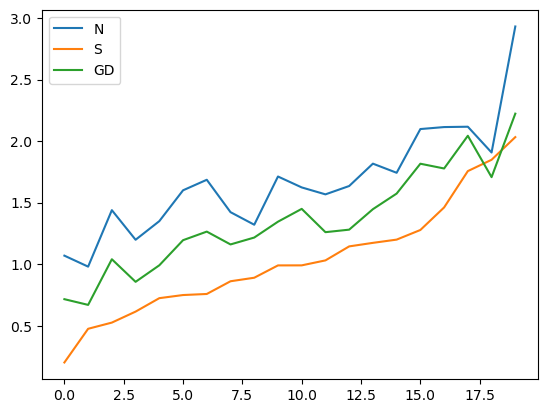

In [11]:
plt.plot(np.array(loss_N)[ind], label='N')
plt.plot(np.array(loss_smcd)[ind], label='S')
plt.plot(np.array(loss_GD)[ind], label='GD')
plt.legend()

In [31]:
def repeat_smcd(n_repeat=10, adapt_timestep=10, n_particles=300):
    l_losses = []
    for _ in range(n_repeat):
        losses = []
        criterion = nn.MSELoss()
        for i in range(len(adapt_data)):
            q = adapt_data[i]['angle'].to(torch.float32).swapaxes(1,0)
            x = adapt_data[i]['true_pos'].to(torch.float32).swapaxes(1,0)
            M_best = smcd(adapt_timestep, n_particles, adapt_data[i], d=0.15)
            model = load_model()
            model.update_dropout_mask(M_best[-1].reshape(1,-1))
            x_pred = model(q).detach()
            loss = criterion(x_pred, x)

            losses.append(loss.item())
        l_losses.append(losses)
    return l_losses

In [35]:
# %%capture capt #disable the printing
l_losses = repeat_smcd(10, 100, 1000)

100%|██████████| 100/100 [00:02<00:00, 48.21it/s]


In [36]:
np.save('loss_adapt/losses_smcd_repeated',l_losses)

In [47]:
l_losses = np.load('loss_adapt/losses_smcd_repeated.npy')

In [73]:
ind = np.argsort(l_losses[0])

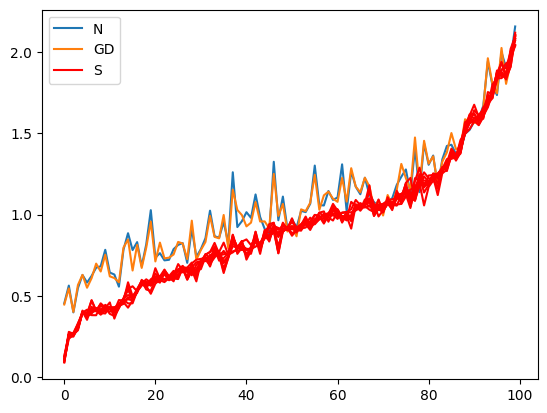

In [82]:
plt.plot(loss_N[ind], label='N')
plt.plot(loss_GD[ind], label='GD')

for i in range(len(l_losses)):
    plt.plot(l_losses[i][ind], color='r', label='SMCD' if i == 0 else "")
plt.legend()

# Prediction

In [9]:
test_data[0].keys()

dict_keys(['init_angle', 'init_pos', 'target_pos', 'true_pos', 'noisy_pos'])

In [27]:
def plot_trace(t, start=0, end=-1):
	init_pos = t['init_pos'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	plt.figure()
	plt.scatter(*init_pos, label='init_pos')
	plt.scatter(*target_pos, label='target_pos')
	plt.plot(true_pos[start:end,0], true_pos[start:end,1], label='true_pos')
	plt.legend()

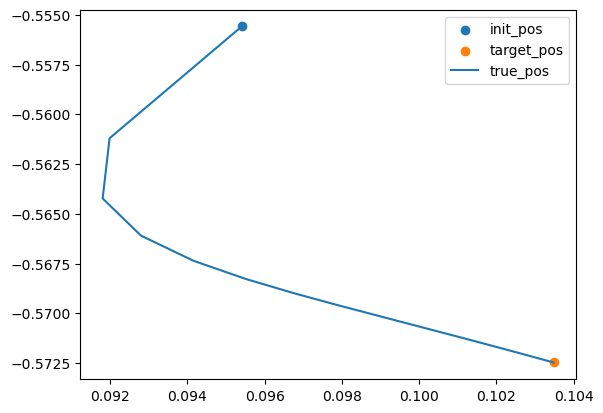

In [37]:
plot_trace(test_data[99], 0, 200)

In [148]:
def test_smcd(mask_per_task, n_tasks = -1):
	trace_pred = []
	trace_true = []
	criterion = nn.MSELoss()
	with tqdm(test_data[0:n_tasks], unit='task')as tepoch:
		for i, task in enumerate(tepoch):
			trace_pred_i = np.array([])
			trace_true_i = np.array([])
			model = load_model()
			q0 = task['init_angle'].to(dtype=torch.float32)
			xg = task['target_pos']
			x_oracle = task['true_pos']
			model.update_dropout_mask(mask_per_task[i])
			q = q0
			u = 0
			l = dataset.l[i]
			x0 = task['init_pos']
			x0_pred = model(q0)
			loss = criterion(x0_pred, x0)
			print(loss)
			for t in range(len(x_oracle)):
				x_pred = model(q).detach()
				x_true = fk(q, l)
				# emit control from predicted position
				u = pd(q, x_pred, xg, u, k=[1,1e-2], l=l)
				q += u
				# normalize
				q = np.mod(q, 2 * np.pi)
				q[q>np.pi] -= 2*np.pi
				# the system evolve subject to control and real setting
				# print(x_pred)
				# print(x_true)
				trace_pred_i = np.append(trace_pred_i, x_pred.numpy(), axis=0)
				trace_true_i = np.append(trace_true_i, x_true, axis=0)
			trace_pred.append(trace_pred_i.reshape(-1,2))
			trace_true.append(trace_true_i.reshape(-1,2))
	return trace_pred, trace_true


In [156]:
q = np.pi + 1
np.mod(q, 2 * np.pi) - np.pi

1.0

In [149]:
trace_pred, trace_true = test_smcd(M_best_per_task, 5)

  0%|          | 0/5 [00:00<?, ?task/s]

tensor(0.2336, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 20%|██        | 1/5 [00:00<00:01,  2.43task/s]

tensor(0.0029, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 40%|████      | 2/5 [00:00<00:01,  2.67task/s]

tensor(0.0099, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 60%|██████    | 3/5 [00:01<00:00,  2.62task/s]

tensor(0.8566, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 80%|████████  | 4/5 [00:01<00:00,  2.39task/s]

tensor(0.0810, dtype=torch.float64, grad_fn=<MseLossBackward0>)


100%|██████████| 5/5 [00:01<00:00,  2.50task/s]


In [151]:
def plot_trace(i, start=0, end=-1):
	t = test_data[i]
	init_pos = t['init_pos'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	plt.figure()
	plt.scatter(*init_pos, label='init_pos')
	plt.scatter(*trace_true[i][start], marker='o')
	plt.scatter(*trace_pred[i][start], marker='o')
	plt.scatter(*trace_true[i][end], marker='^')
	plt.scatter(*trace_pred[i][end], marker='^')
	plt.plot(true_pos[start:end,0], true_pos[start:end,1], label='oracle_pos')
	plt.plot(trace_true[i][start:end,0], trace_true[i][start:end,1], label='true_pos')
	plt.plot(trace_pred[i][start:end,0], trace_pred[i][start:end,1], label='pred_pos')
	plt.scatter(*target_pos, label='target_pos')
	plt.legend()

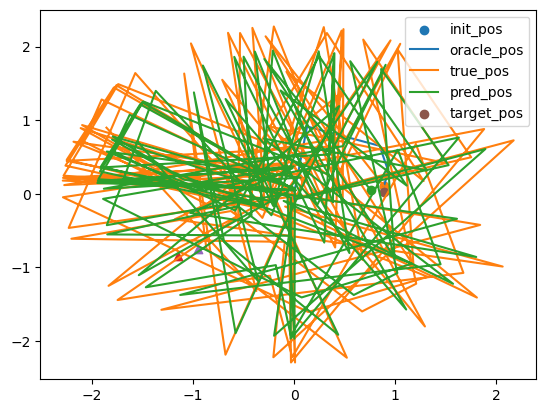

In [154]:
plot_trace(2, 0, 100)